## Cross Validation Search for Optimal K

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

#### Data Generating Process

In [2]:
# Simulate S1 and S2
def simulate_S1_S2(num_points1, num_points2): 
    np.random.seed(26) # set random seed
    
    locations1 = np.random.rand(num_points1, 2) * 100

    centers = [(30, 30), (70, 70), (30, 70), (70, 30)]  # Four clusters
    locations2, _ = make_blobs(n_samples=num_points2, centers=centers, cluster_std=10.0, random_state=26)

    locations2 = np.clip(locations2, 0, 100)

    s1 = np.random.normal(50, 10, num_points1)  # Target support observations
    s2 = np.random.normal(100, 50, num_points2) # Source support observations

    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(200, 350) # Increase data of s1 and s2 to 200 and 350

# Simulate beta surface

def create_surface(locations):
    x = locations[:, 0]
    y = locations[:, 1]
    B = x + y  # True beta surface defined on target support S1
    return B

B = create_surface(loc1)

# Number of neighbors for smoothing (DGP-specific)
n_neighbor_dgp = 35

smoothed_S2_to_S1 = np.zeros(len(S1))

# Use KNN to smooth X values from S2 onto S1
nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_dgp).fit(loc2)

for i in range(len(S1)):
    # Find neighbors of S1 location i in S2
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

    # Aggregate the X values from S2 using a simple mean for the DGP (this is not the regression step)
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1  

### COS Local regression AND beta recovery

In [3]:
# Define functions to compute MSE
def compute_mse(true_betas, recovered_betas):
    mse = np.mean((true_betas - recovered_betas) ** 2)
    return mse

# Function for local regression and beta recovery
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    recovered_betas = np.zeros(len(loc1))

    for i in range(len(loc1)):
        local_X = []
        weights_X = []

        # Initialize Nearest Neighbors model to find neighbors in S2 for current S1_i
        nbrs_S2 = NearestNeighbors(n_neighbors=min(n_neighbor_est, len(loc2))).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])

        # Compute weights for the selected neighbors in S2 based on distance to S1_i
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            
            weight = np.exp(-0.5 * (dist_j_to_i / 10) ** 2)

            # Collect S2 observation and its weight
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)

        # Apply the computed weights to the selected S2 observations (X values)
        # This effectively smooths the S2 observations towards S1_i
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Perform local regression using the weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=min(n_neighbor_est, len(loc1))).fit(loc1)  # Adjust n_neighbors
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]]
        X_neighbors = weighted_X_i * np.ones(len(indices[0]))
        weights_y = np.exp(-0.5 * (distances[0] / 10) ** 2)
        W_y = np.sqrt(weights_y)

        X_weighted = (X_neighbors * W_y).reshape(-1, 1)
        y_weighted = y_neighbors * W_y

        model = LinearRegression(fit_intercept=True)
        model.fit(X_weighted, y_weighted)

        # Store recovered beta
        recovered_betas[i] = model.coef_[0]

    return recovered_betas

### Cross Validation routine

In [4]:
# Cross-Validation Function
def cross_validation_k_fold(loc1, loc2, S2, y, B, k_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=26)
    cv_mse_results = {k: [] for k in k_values}
    
    for train_index, test_index in kf.split(loc1):
        loc1_train, loc1_test = loc1[train_index], loc1[test_index]
        y_train, y_test = y[train_index], y[test_index]
        B_test = B[test_index]  # True betas for comparison
        
        for k in k_values:
            # Perform local regression to get recovered betas for the training set
            recovered_betas_train = perform_local_regression(n_neighbor_est=min(k, len(loc1_train)), loc1=loc1_train, loc2=loc2, S2=S2, y=y_train)
            
            # Evaluate on the test set using indices specific to the test data
            recovered_betas_test = perform_local_regression(n_neighbor_est=min(k, len(loc1_test)), loc1=loc1_test, loc2=loc2, S2=S2, y=y_test)
            
            # Calculate MSE on the test set
            mse = compute_mse(B_test, recovered_betas_test)
            cv_mse_results[k].append(mse)
    
    # Calculate mean MSE for each k
    cv_mse_mean = {k: np.mean(cv_mse_results[k]) for k in k_values}
    
    return cv_mse_mean

Cross-Validation MSE Results: {5: 1083.6357163223997, 10: 245.3902768946613, 15: 135.35798918553957, 20: 86.1760962472984, 25: 65.35216818875918, 30: 54.975138111083574, 35: 47.07937024158919, 40: 42.87729208434289, 45: 42.87729208434289, 50: 42.87729208434289, 55: 42.87729208434289, 60: 42.87729208434289, 65: 42.87729208434289, 70: 42.87729208434289, 75: 42.87729208434289, 80: 42.87729208434289, 85: 42.87729208434289, 90: 42.87729208434289, 95: 42.87729208434289, 100: 42.87729208434289, 105: 42.87729208434289, 110: 42.87729208434289, 115: 42.87729208434289, 120: 42.87729208434289, 125: 42.87729208434289, 130: 42.87729208434289, 135: 42.87729208434289, 140: 42.87729208434289, 145: 42.87729208434289, 150: 42.87729208434289, 155: 42.87729208434289, 160: 42.87729208434289, 165: 42.87729208434289, 170: 42.87729208434289, 175: 42.87729208434289, 180: 42.87729208434289, 185: 42.87729208434289, 190: 42.87729208434289, 195: 42.87729208434289}


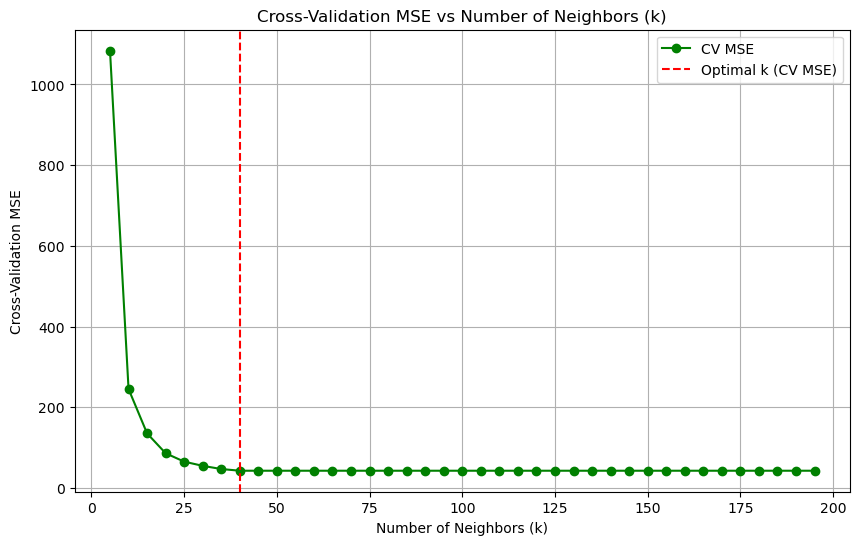

In [7]:
# Perform cross-validation for different k values
k_values = list(range(5, 200, 5)) # set search range of 5-200 with a stepsize of 5

cv_mse_results = cross_validation_k_fold(loc1, loc2, S2, y, B, k_values)

print("Cross-Validation MSE Results:", cv_mse_results)

# Plot Cross-Validation MSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, list(cv_mse_results.values()), marker='o', linestyle='-', color='green', label='CV MSE')
plt.axvline(min(cv_mse_results, key=cv_mse_results.get), color='red', linestyle='--', label=f'Optimal k (CV MSE)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation MSE')
plt.title('Cross-Validation MSE vs Number of Neighbors (k)')
plt.legend()
plt.grid(True)
plt.show()


### Optimal K Value

In [8]:
min(cv_mse_results, key=cv_mse_results.get)


40